In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')

import pandas as pd
import tensorflow as tf
import keras as keras
from keras import layers

from skimage.util import random_noise
from skimage.filters import threshold_multiotsu

Mounted at /content/drive


In [2]:
from scipy.signal import convolve2d

In [3]:
# function to add Gaussian noise to image
def addNoise(img, noiseFactor):
  h = len(img)
  w = len(img[0])
  noise_img = 255*random_noise(img, mode='s&p',amount=noiseFactor)
  return noise_img

def preprocess(img, noise=False, noiseFactor=None):
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  r,g,b = cv2.split(rgb_img)
  for i in range(len(g)):
    for j in range(len(g[i])):
      g[i][j] = 0

  rgb = np.dstack((b,g,r))

  hsv_img = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)
  h,s,v = cv2.split(hsv_img)
  hsv_split = np.concatenate((h,s,v),axis=1)

  thresholds = threshold_multiotsu(v, classes=3)
  if noise: v = addNoise(v, noiseFactor)

  # Using the threshold values, we generate the three regions.
  regions = np.digitize(v, bins=thresholds)

  return regions

def cutImageUp(img, w, h):
  rowRange = range(0, len(img)//w * w, w)
  colRange = range(0, len(img[0])//h * h, h)
  cutup = np.zeros(((len(rowRange)) * (len(colRange)), w, h, 1))
  index = 0
  for (ri, i) in enumerate(rowRange):
    for (ci, j) in enumerate(colRange):
      cutup[index] = np.reshape(img[i : (i + w), j : (j + h)], (w, h, 1))
      index = index + 1
  return cutup

def stitchTogether(cutImg, w, h):
  dim = cutImg[0].shape
  w_i, h_i = dim[0], dim[1]
  n = len(cutImg)

  rangeW = w // w_i
  rangeH = h // h_i

  img_lst = []

  cnt = 0
  for j in range(0, rangeH):
    lst = []
    for i in range(0, rangeW):
      if cnt >= n:
         return cv2.vconcat(img_lst)
      lst.append(cutImg[cnt])
      cnt += 1
    img_lst.append(cv2.hconcat(lst))



  return cv2.vconcat(img_lst)

In [4]:
nodefect_autoencoder = keras.models.load_model('/content/drive/MyDrive/ENEE 439D Final Project/Aerospace PCB Our Pics/nodefectReconstruct')

In [60]:
def classify_regular_pcb(file_path, preprocessBool=True, invert=False):
  img = cv2.imread(file_path)
  if not preprocessBool: 
    img[img > 255/2] = 255.
    img[img < 255/2] = 0.
    if invert: img = (255 - img)/255
    if not invert: img = img/255
    r,g,b = cv2.split(img)
    img = r
    
  if preprocessBool: 
    img = preprocess(img)
    img[img > 0.5] = 1.
    img[img < 0.5] = 0.
  #cv2_imshow(img*255)
  
  cutup = cutImageUp(img, 80, 80)
  prediction = nodefect_autoencoder.predict(cutup, verbose=1)
  prediction = np.reshape(prediction, np.shape(prediction)[:-1])
  h, w = img.shape

  # scale up images
  prediction = [img for img in prediction]
  cutup = [img for img in cutup]

  pred_full = stitchTogether(prediction, w, h)
  #cv2_imshow(pred_full*255)
 
  original_img = stitchTogether(cutup, w, h)
  difference = np.subtract(original_img, pred_full)
  difference[difference < 0.] = 0.
  sum_kernel = np.tile(1/4., (2, 2))
  difference = convolve2d(difference, sum_kernel, 'same')
  difference[difference < 0.5] = 0
  difference[difference >= 0.5] = 1
  #cv2_imshow(difference*255)
  return difference
  

In [61]:
def defect_segmentation_mask(template, test, defects,
                             preprocessBool = False, 
                             invert = False, 
                             bb = True):
  template = cv2.imread(template)
  img = template
  if not preprocessBool: 
    img[img > 255/2] = 255.
    img[img < 255/2] = 0.
    if invert: img = (255 - img)/255
    if not invert: img = img/255
    r,g,b = cv2.split(img)
    img = r
    
  if preprocessBool: 
    img = preprocess(img)
    img[img > 0.5] = 1.
    img[img < 0.5] = 0.

  template = img

  test = cv2.imread(test)
  img = test
  if not preprocessBool: 
    img[img > 255/2] = 255.
    img[img < 255/2] = 0.
    if invert: img = (255 - img)/255
    if not invert: img = img/255
    r,g,b = cv2.split(img)
    img = r
    
  if preprocessBool: 
    img = preprocess(img)
    img[img > 0.5] = 1.
    img[img < 0.5] = 0.
    
  test = img
  difference = np.abs(np.subtract(test, template))

  if bb:
    for i in range(len(difference)):
      for j in range(len(difference[0])):
        valid = False
        for defect in defects:
          if defect[-1] in [1] and defect[1] <= i and i <= defect[3] and defect[0] <= j and j <= defect[2]:
            valid = True
        if not valid: difference[i, j] = 0

  return difference

In [ ]:
annotationPath = "/content/drive/MyDrive/ENEE 439D Final Project/DeepPCBEval/group50600/50600_not/50600010.txt"
f = open(annotationPath)
defects = []
for line in f:
  line = line[:-1]
  s = line.split(" ")
  s = [int(e) for e in s]
  defects.append(s)

In [ ]:
defect_segmentation_mask("/content/drive/MyDrive/ENEE 439D Final Project/DeepPCBEval/group50600/50600/50600010_temp.jpg",
                         "/content/drive/MyDrive/ENEE 439D Final Project/DeepPCBEval/group50600/50600/50600010_test.jpg",
                         defects)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
def quantify_group(groupNum):
  filePath = "/content/drive/MyDrive/ENEE 439D Final Project/DeepPCBEval/group" + \
             str(groupNum) + "/" + str(groupNum) + "/"
  
  annotationPath = "/content/drive/MyDrive/ENEE 439D Final Project/DeepPCBEval/group" + \
                     str(groupNum) + "/" + str(groupNum) + "_not" + "/"

  precisions = np.asarray([])
  recalls = np.asarray([])
  p = 0
  for i in os.listdir(annotationPath):
    f = open(annotationPath + i)
    defects = []
    for line in f:
      line = line[:-1]
      s = line.split(" ")
      s = [int(e) for e in s]
      defects.append(s)

    difference = classify_regular_pcb(filePath + i.split(".")[0] + "_test.jpg", preprocessBool=False, invert=False)

    defect_mask = defect_segmentation_mask(filePath + i.split(".")[0] + "_temp.jpg",
                                           filePath + i.split(".")[0] + "_test.jpg",
                                           defects)

    #cv2_imshow(difference*255)
    #cv2_imshow(defect_mask*255)


    false_positive = np.subtract(difference, defect_mask) 
    false_positive[false_positive < 0] = 0

    true_positive = np.subtract(difference, false_positive)

    #cv2_imshow(false_positive*255)
    #cv2_imshow(true_positive*255)

    precision = np.sum(true_positive) / np.sum(false_positive + true_positive)
    #print(precision)


    false_negative = np.subtract(defect_mask, difference)
    false_negative[false_negative < 0] = 0

    #cv2_imshow(false_negative*255)
    
    recall = np.sum(true_positive) / np.sum(false_negative + true_positive)
    if  np.sum(false_negative + true_positive) == 0.0:
      recall = 0.0
    #print(recall)

    recalls = np.append(recalls, recall)
    precisions = np.append(precisions, precision)

    if precision > 0.3:
      print(i)

    p+=1
    #if p == 10:
    #  break
  
  print(np.average(precisions))
  print(np.average(recalls))


In [45]:
quantify_group(50600)

2/2 [==============================] - 0s 151ms/step
0.0
0.0


<ipython-input-44-5e1c9dc9eb13>:47: RuntimeWarning: invalid value encountered in double_scalars
  recall = np.sum(true_positive) / np.sum(false_negative + true_positive)


2/2 [==============================] - 0s 144ms/step
0.01282051282051282
0.01834862385321101
2/2 [==============================] - 1s 240ms/step
0.400990099009901
0.11005434782608696
2/2 [==============================] - 1s 245ms/step
0.0728476821192053
0.08906882591093117
2/2 [==============================] - 0s 239ms/step
0.11206896551724138
0.12149532710280374
2/2 [==============================] - 0s 131ms/step
0.10606060606060606
0.14736842105263157
2/2 [==============================] - 0s 124ms/step
0.0
0.0
2/2 [==============================] - 0s 135ms/step
0.01557632398753894
0.011389521640091117
2/2 [==============================] - 0s 139ms/step
0.19791666666666666
0.36893203883495146
2/2 [==============================] - 0s 130ms/step
0.0345821325648415
0.08450704225352113
2/2 [==============================] - 0s 133ms/step
0.07987220447284345
0.029797377830750895
2/2 [==============================] - 1s 258ms/step
0.005813953488372093
0.030612244897959183
2/2 [====

In [46]:
quantify_group(77000)

2/2 [==============================] - 1s 243ms/step
0.10843373493975904
0.020361990950226245
2/2 [==============================] - 0s 152ms/step
0.3142857142857143
0.02029520295202952
2/2 [==============================] - 0s 126ms/step
0.006097560975609756
0.0009285051067780873
2/2 [==============================] - 0s 135ms/step
0.0
0.0
2/2 [==============================] - 0s 133ms/step
0.49193548387096775
0.16598639455782313
2/2 [==============================] - 0s 126ms/step
0.0
0.0


<ipython-input-44-5e1c9dc9eb13>:47: RuntimeWarning: invalid value encountered in double_scalars
  recall = np.sum(true_positive) / np.sum(false_negative + true_positive)


2/2 [==============================] - 0s 137ms/step
0.0
0.0
2/2 [==============================] - 0s 124ms/step
0.6016949152542372
0.05858085808580858
2/2 [==============================] - 0s 229ms/step
0.0
0.0
2/2 [==============================] - 0s 237ms/step
0.0
0.0
2/2 [==============================] - 0s 129ms/step
0.050980392156862744
0.024714828897338403
2/2 [==============================] - 0s 134ms/step
0.1457142857142857
0.11971830985915492
2/2 [==============================] - 0s 125ms/step
0.0
0.0
2/2 [==============================] - 0s 129ms/step
0.2807017543859649
0.04678362573099415
2/2 [==============================] - 0s 126ms/step
0.0
0.0
2/2 [==============================] - 0s 134ms/step
0.3870967741935484
0.011059907834101382
2/2 [==============================] - 0s 133ms/step
0.11244979919678715
0.036939313984168866
2/2 [==============================] - 0s 142ms/step
0.0
0.0
2/2 [==============================] - 1s 271ms/step
0.0
0.0
2/2 [==========

In [68]:
quantify_group(92000)

2/2 [==============================] - 0s 136ms/step


<ipython-input-67-163fb3bbab6a>:47: RuntimeWarning: invalid value encountered in double_scalars
  recall = np.sum(true_positive) / np.sum(false_negative + true_positive)


2/2 [==============================] - 0s 122ms/step
92000039.txt
2/2 [==============================] - 0s 132ms/step
92000014.txt
2/2 [==============================] - 0s 123ms/step
92000025.txt
2/2 [==============================] - 0s 132ms/step
92000035.txt
2/2 [==============================] - 0s 126ms/step
92000017.txt
2/2 [==============================] - 1s 245ms/step
92000034.txt
2/2 [==============================] - 0s 132ms/step
92000024.txt
2/2 [==============================] - 0s 124ms/step
92000013.txt
2/2 [==============================] - 0s 122ms/step
92000042.txt
2/2 [==============================] - 0s 137ms/step
92000026.txt
2/2 [==============================] - 0s 137ms/step
92000046.txt
2/2 [==============================] - 0s 121ms/step
92000031.txt
2/2 [==============================] - 0s 234ms/step
92000041.txt
2/2 [==============================] - 0s 239ms/step
92000032.txt
2/2 [==============================] - 0s 141ms/step
92000002.txt
2/2 [=====

In [63]:
quantify_group(92000)

2/2 [==============================] - 0s 233ms/step


<ipython-input-62-6591b979dd33>:47: RuntimeWarning: invalid value encountered in double_scalars
  recall = np.sum(true_positive) / np.sum(false_negative + true_positive)


2/2 [==============================] - 0s 126ms/step
92000111.txt
2/2 [==============================] - 0s 241ms/step
0.2704948242760423
0.045725874537938395


2/2 [==============================] - 0s 137ms/step


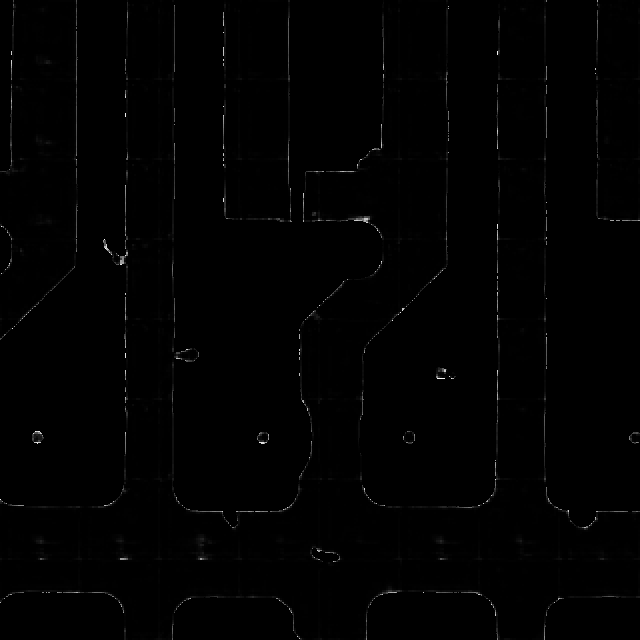

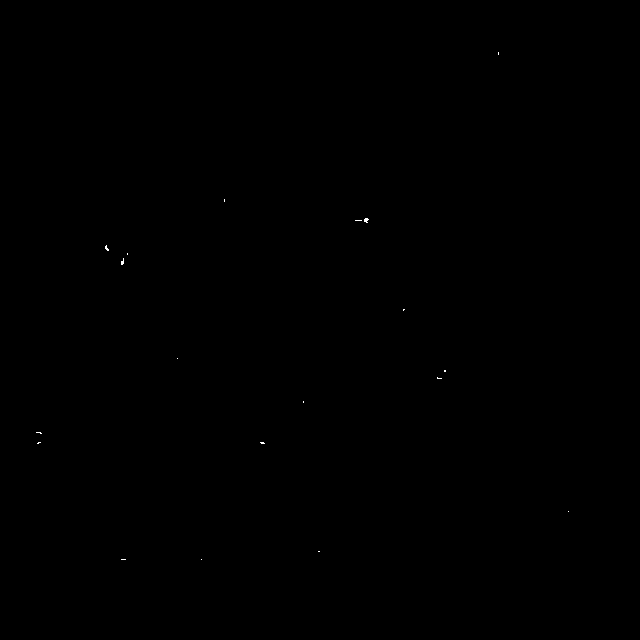

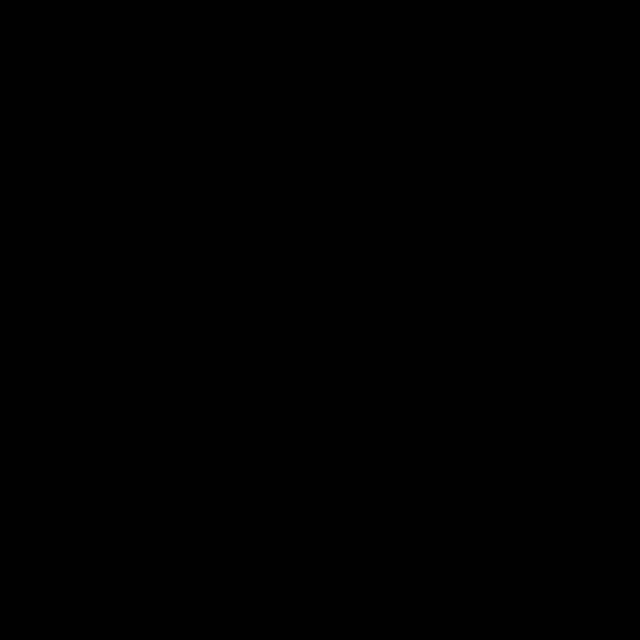

0.0
0.0


<ipython-input-51-f6096e69f897>:47: RuntimeWarning: invalid value encountered in double_scalars
  recall = np.sum(true_positive) / np.sum(false_negative + true_positive)


2/2 [==============================] - 0s 137ms/step


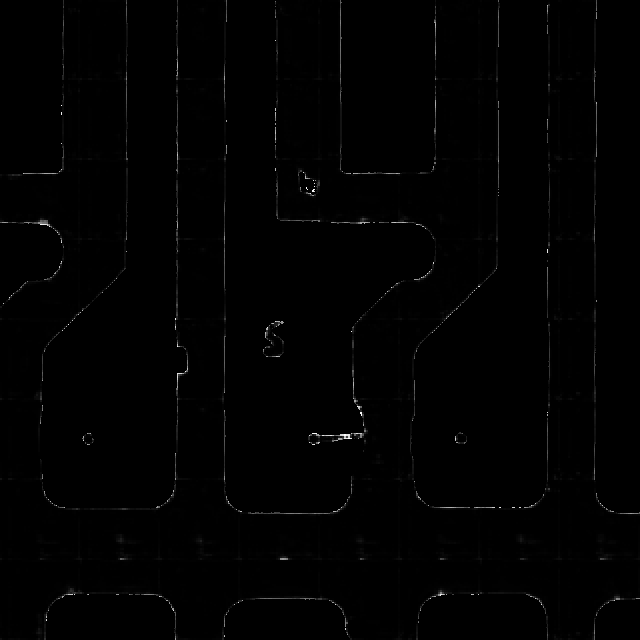

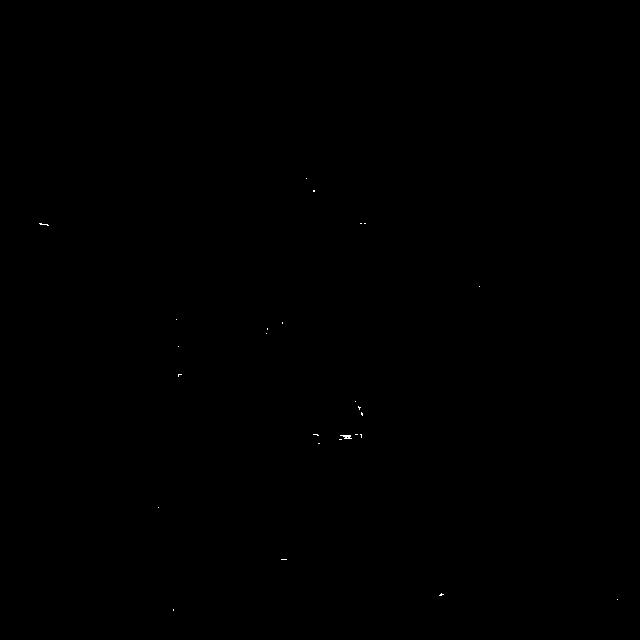

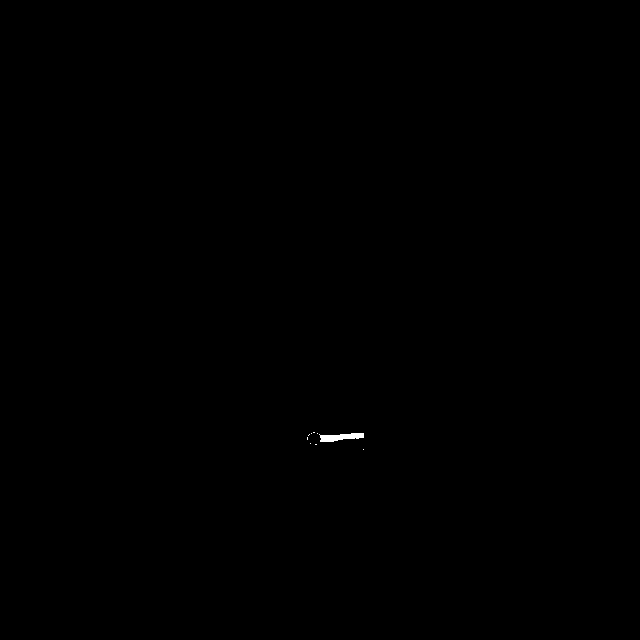

0.3559322033898305
0.15328467153284672
2/2 [==============================] - 0s 138ms/step


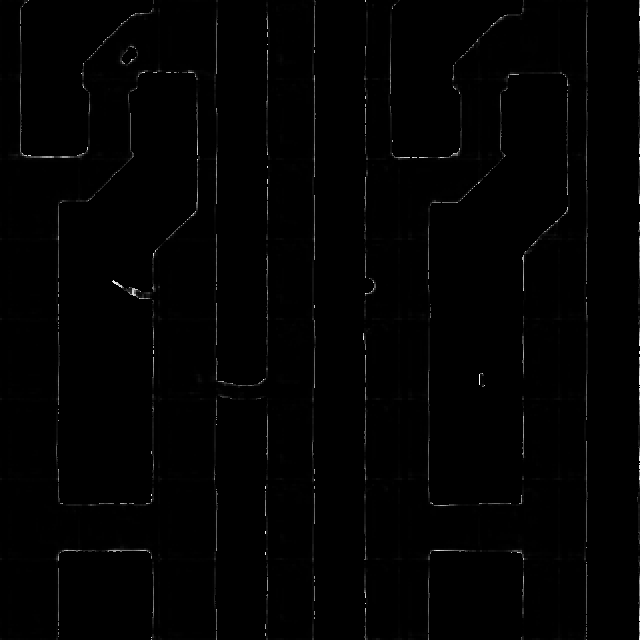

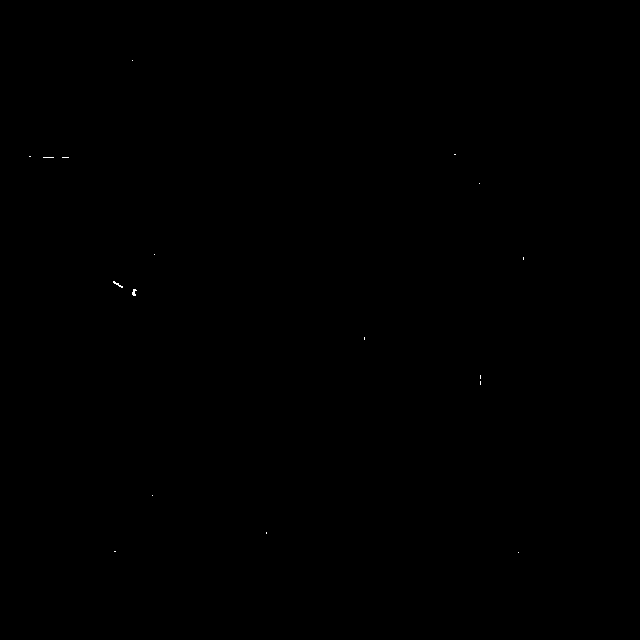

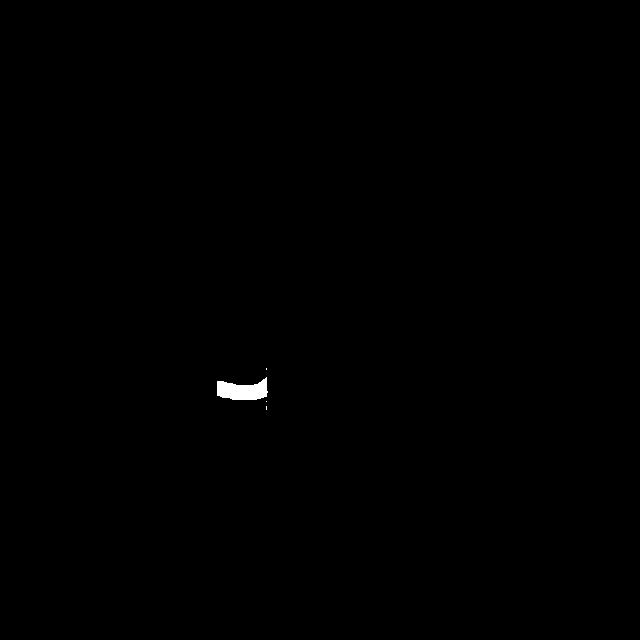

0.0
0.0
2/2 [==============================] - 0s 135ms/step


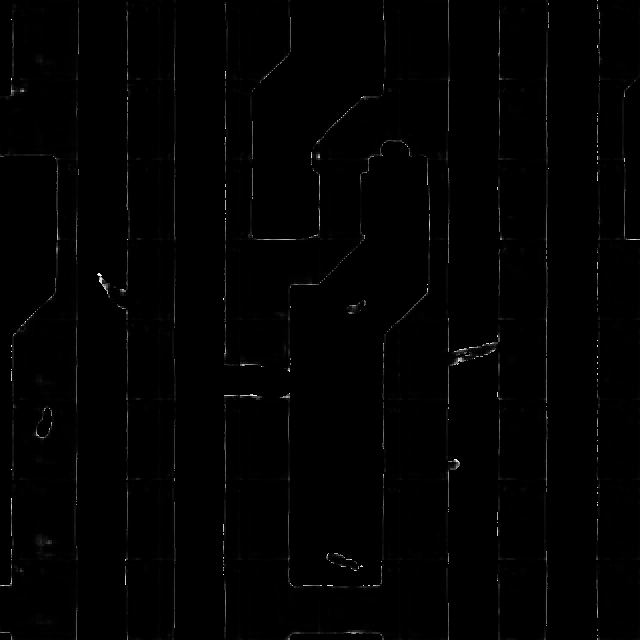

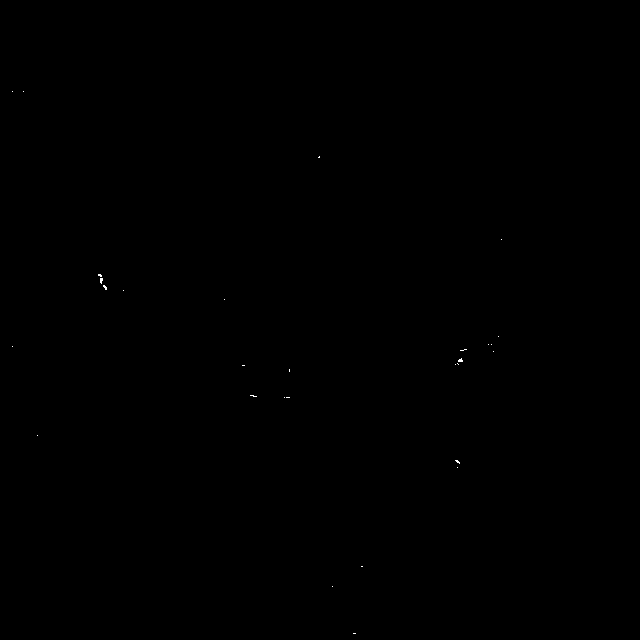

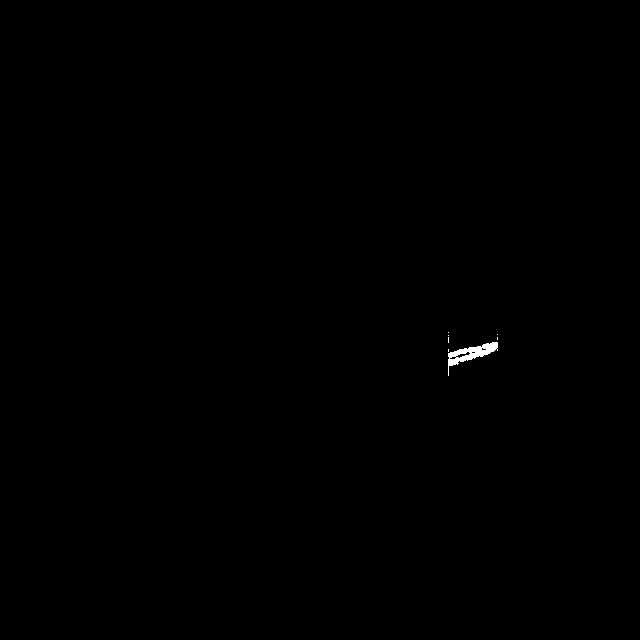

0.22935779816513763
0.04440497335701599
2/2 [==============================] - 0s 126ms/step


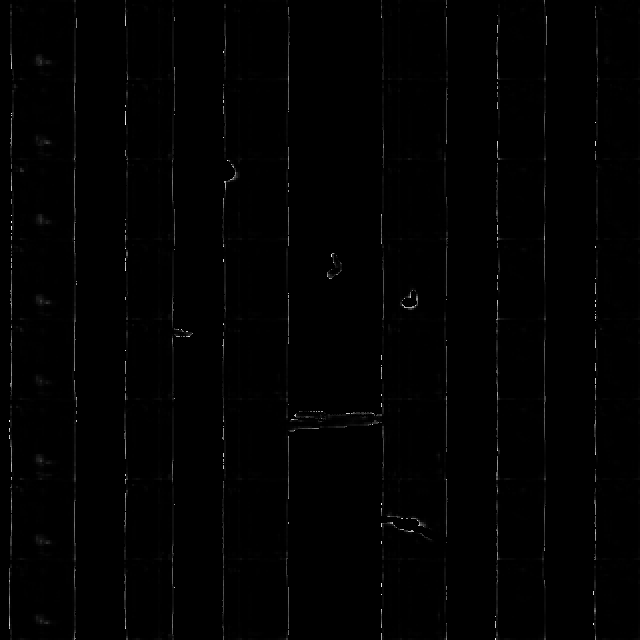

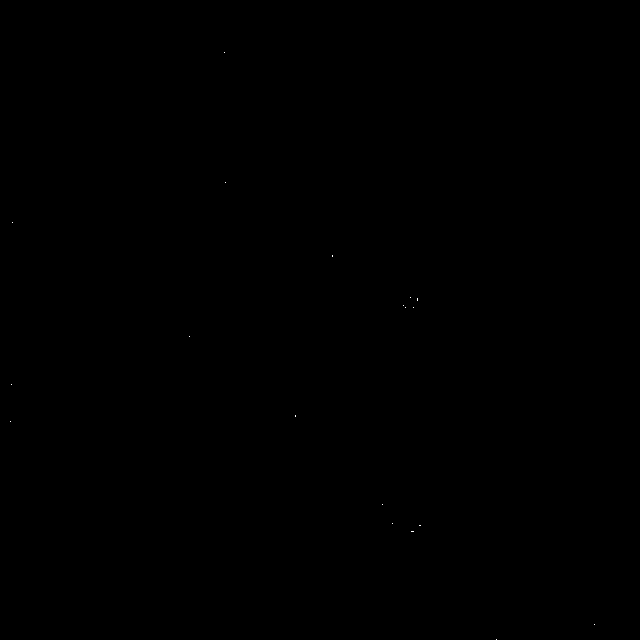

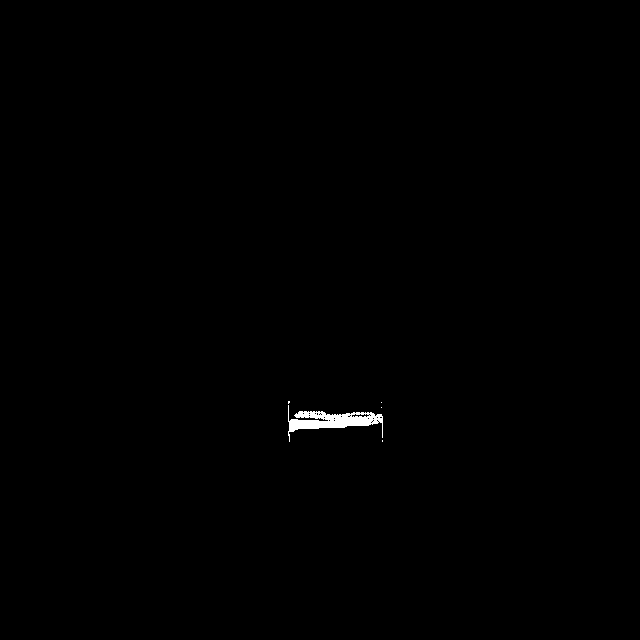

0.07692307692307693
0.0015772870662460567
2/2 [==============================] - 0s 132ms/step


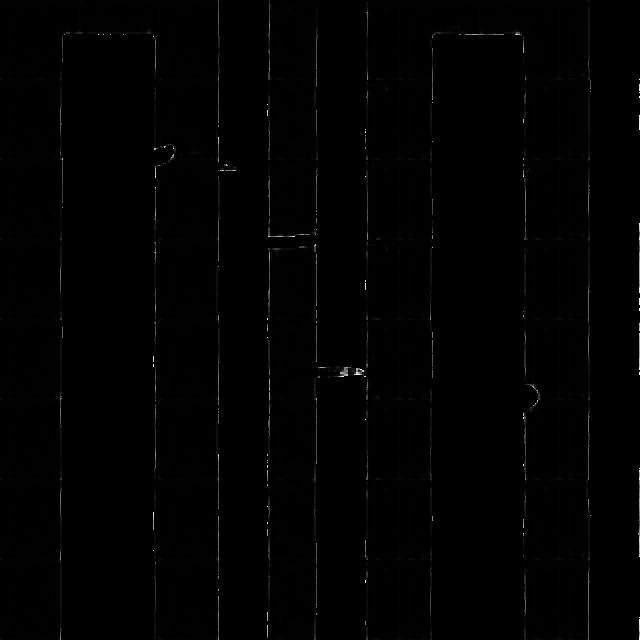

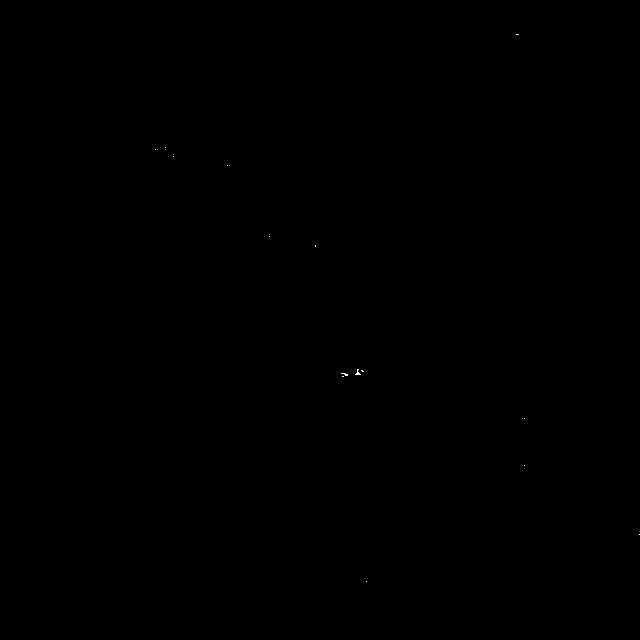

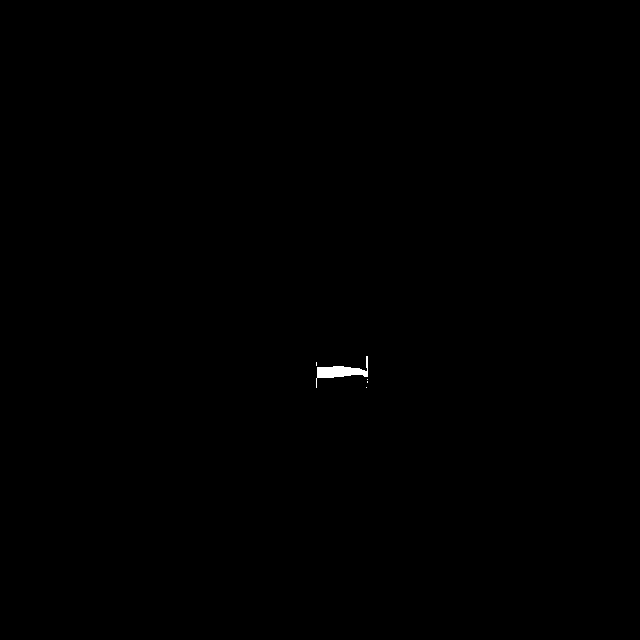

0.7083333333333334
0.06576402321083172
2/2 [==============================] - 0s 131ms/step


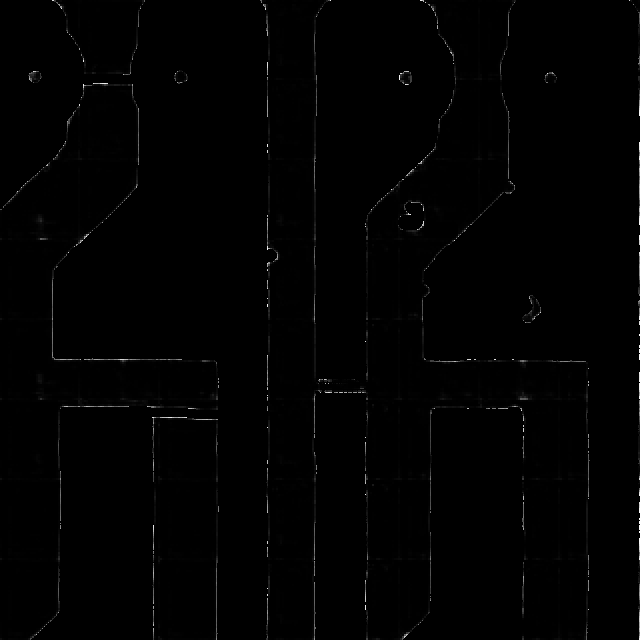

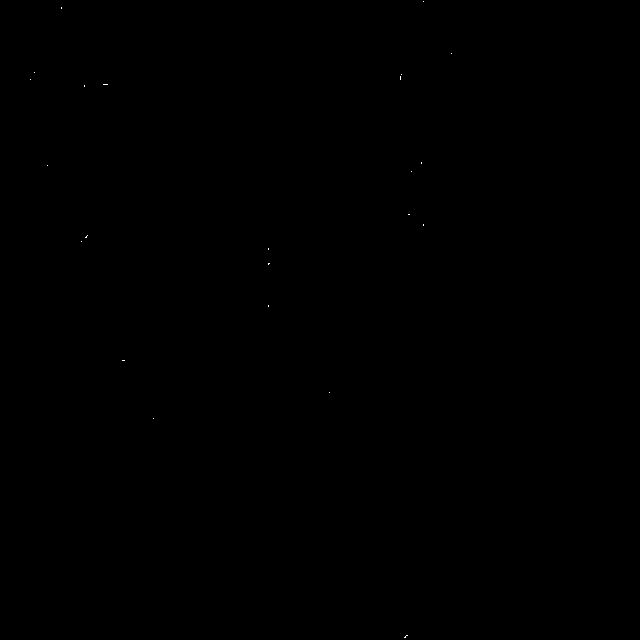

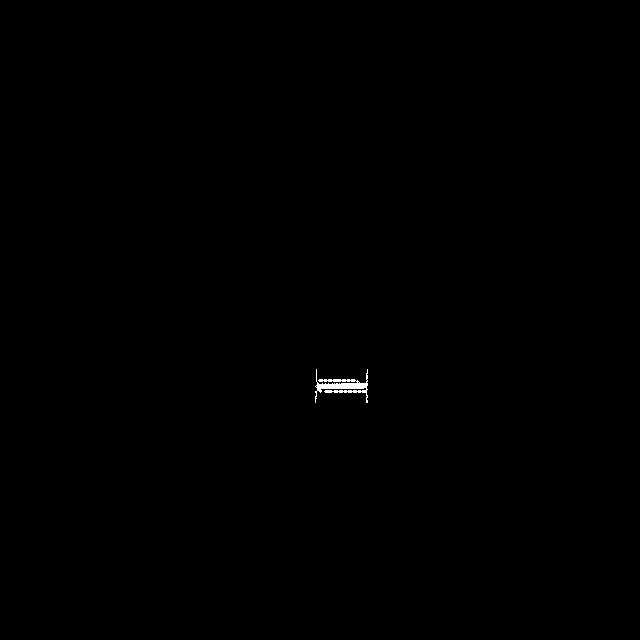

0.020833333333333332
0.0017094017094017094
2/2 [==============================] - 0s 124ms/step


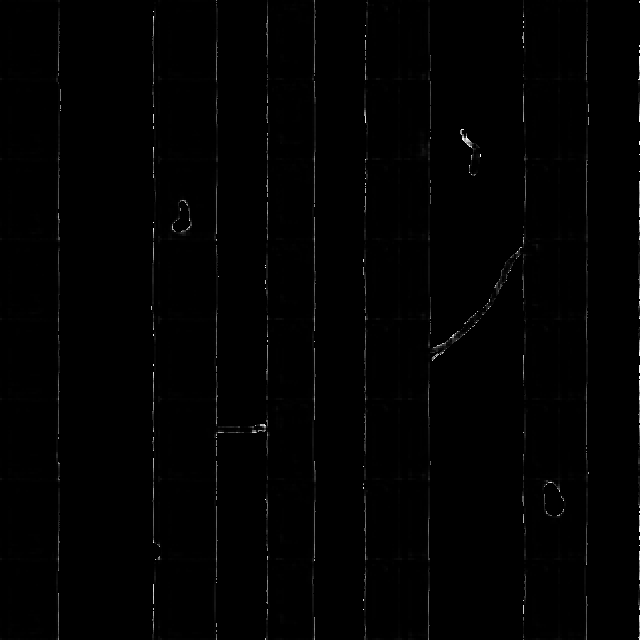

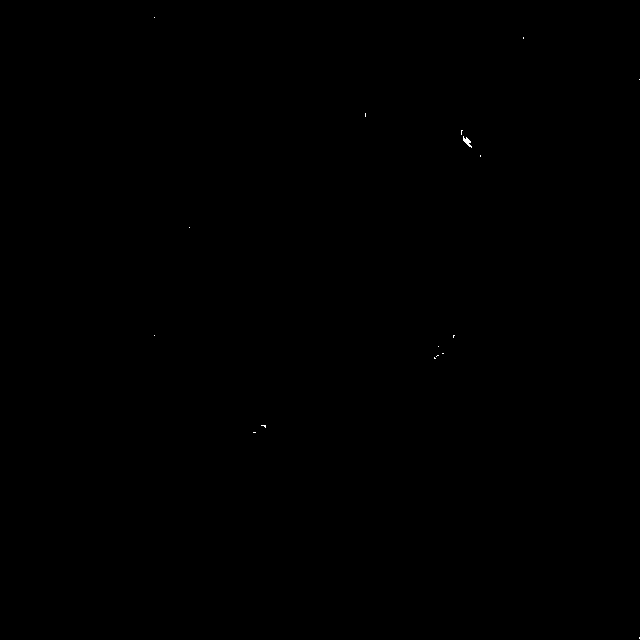

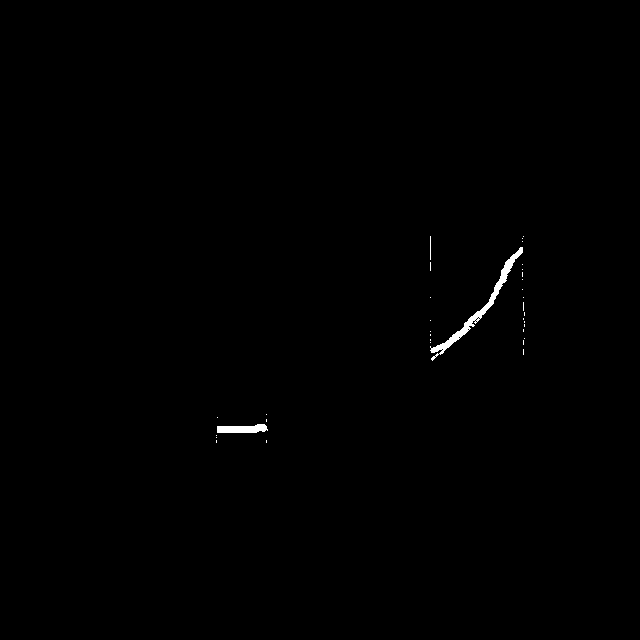

0.23333333333333334
0.015306122448979591
2/2 [==============================] - 0s 215ms/step


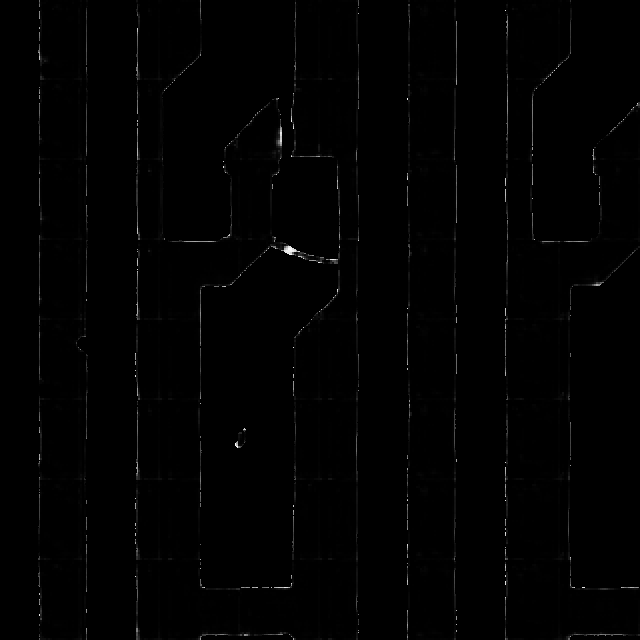

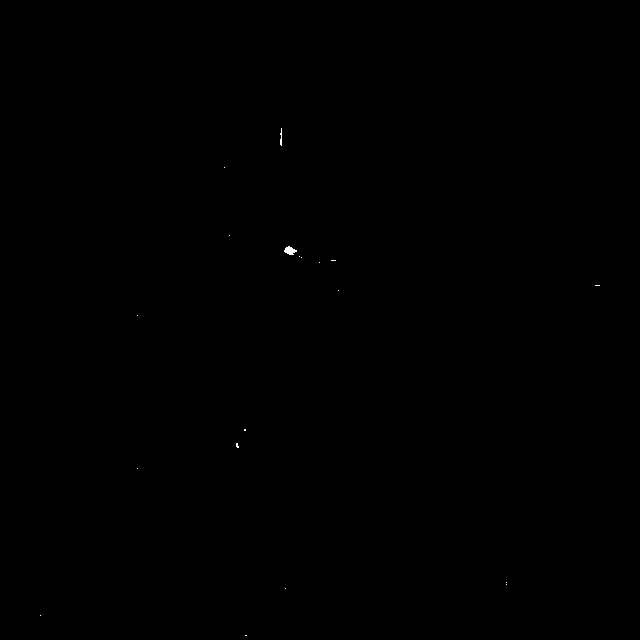

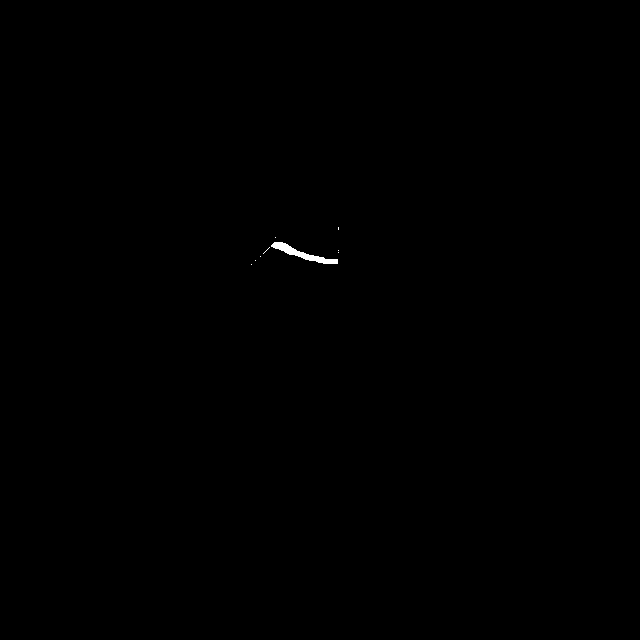

0.5869565217391305
0.1836734693877551
2/2 [==============================] - 0s 228ms/step


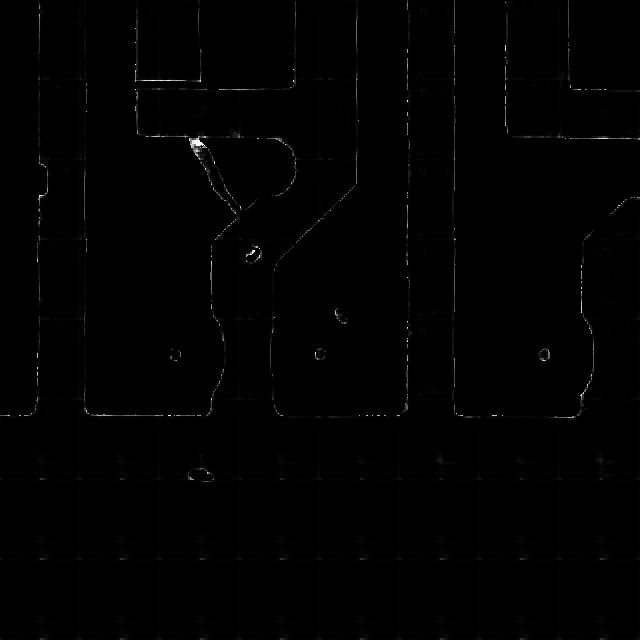

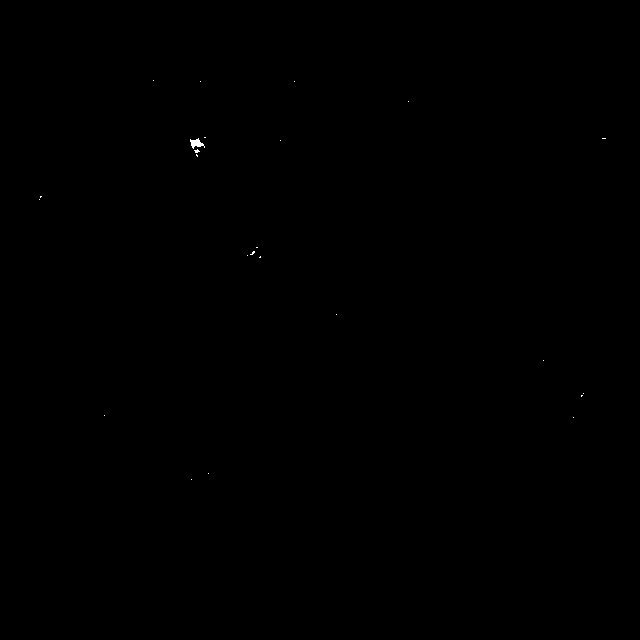

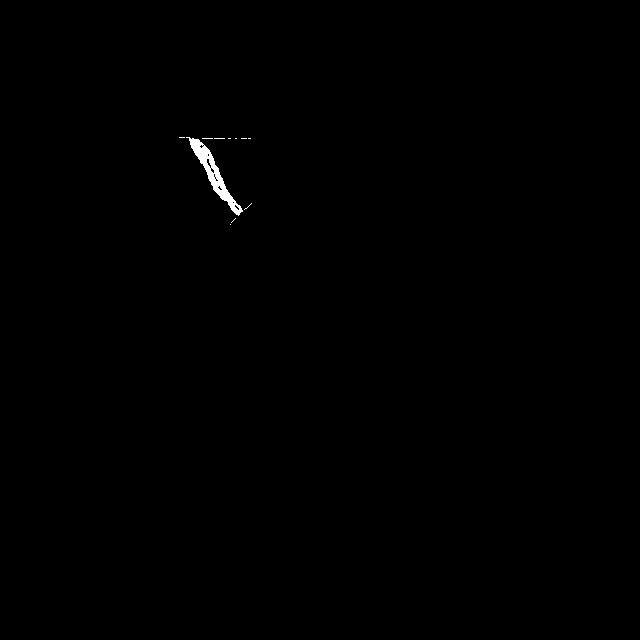

0.6875
0.10030395136778116
0.2899169600217176
0.0566023900080858


In [52]:
quantify_group(92000)